# GM(1,1)灰色预测模型 - 案例二：企业销售额预测
# 数学建模课程练习


In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 设置图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [122]:
print("=" * 60)
print("GM(1,1)灰色预测模型 - 企业销售额预测案例")
print("=" * 60)

GM(1,1)灰色预测模型 - 企业销售额预测案例


# 重用前面定义的GM11类（在实际使用中，可以将其保存为单独的模块导入）

In [123]:
class GM11:
    """
    GM(1,1)灰色预测模型类 - 增强版
    
    新增功能：
    1. 敏感性分析
    2. 预测区间估计
    3. 模型比较功能
    """
    
    def __init__(self):
        self.a = None
        self.b = None
        self.x0 = None
        self.x1 = None
        self.n = None
        self.fitted_values = None
        self.model_info = {}
        
    def level_ratio_test(self, data):
        """级比检验函数（增强版）"""
        n = len(data)
        level_ratios = []
        
        for i in range(1, n):
            if data[i] != 0:
                ratio = data[i-1] / data[i]
                level_ratios.append(ratio)
        
        # 改进的检验边界计算
        lambda_val = (n - 1) / (n + 1)
        lower_bound = np.exp(-2 * lambda_val)
        upper_bound = np.exp(2 * lambda_val)
        bounds = (lower_bound, upper_bound)
        
        valid = all(lower_bound <= ratio <= upper_bound for ratio in level_ratios)
        
        # 计算级比的统计特征
        ratio_mean = np.mean(level_ratios)
        ratio_std = np.std(level_ratios)
        
        print(f"📊 级比检验详细结果:")
        print(f"检验边界: ({lower_bound:.4f}, {upper_bound:.4f})")
        print(f"级比均值: {ratio_mean:.4f}")
        print(f"级比标准差: {ratio_std:.4f}")
        print(f"级比序列: {[f'{r:.4f}' for r in level_ratios]}")
        print(f"检验结果: {'✅ 通过' if valid else '❌ 不通过'}")
        
        if not valid:
            print("💡 建议：可尝试数据平滑处理或使用其他预测方法")
        
        return valid, level_ratios, bounds
    
    def fit(self, data, verbose=True):
        """训练GM(1,1)模型（增强版）"""
        self.x0 = np.array(data, dtype=float)
        self.n = len(data)
        
        if verbose:
            print(f"\n📈 原始数据分析:")
            print(f"数据序列: {self.x0}")
            print(f"数据长度: {self.n}")
            print(f"数据范围: [{np.min(self.x0):.2f}, {np.max(self.x0):.2f}]")
            print(f"增长倍数: {self.x0[-1]/self.x0[0]:.2f}")
        
        # 级比检验
        valid, ratios, bounds = self.level_ratio_test(data)
        
        # 存储模型信息
        self.model_info['level_ratio_valid'] = valid
        self.model_info['level_ratios'] = ratios
        self.model_info['bounds'] = bounds
        
        # 一次累加生成
        self.x1 = np.cumsum(self.x0)
        if verbose:
            print(f"\n🔄 累加生成序列: {self.x1}")
        
        # 构造均值序列
        z1 = np.array([0.5 * (self.x1[i] + self.x1[i-1]) for i in range(1, self.n)])
        if verbose:
            print(f"均值序列Z(1): {z1}")
        
        # 构造数据矩阵
        B = np.column_stack((-z1, np.ones(len(z1))))
        Y = self.x0[1:]
        
        # 参数估计
        try:
            params = np.linalg.lstsq(B, Y, rcond=None)[0]
            self.a, self.b = params
            
            # 存储矩阵信息
            self.model_info['B_matrix'] = B
            self.model_info['Y_vector'] = Y
            self.model_info['condition_number'] = np.linalg.cond(B.T @ B)
            
        except np.linalg.LinAlgError as e:
            print(f"❌ 参数估计失败: {e}")
            return
        
        if verbose:
            print(f"\n🎯 模型参数估计:")
            print(f"发展系数 a = {self.a:.6f}")
            print(f"灰作用量 b = {self.b:.4f}")
            print(f"矩阵条件数: {self.model_info['condition_number']:.2f}")
            
            # 参数解释
            if self.a < 0:
                print("📈 系统特征: 增长型")
                growth_rate = -self.a
                print(f"增长强度: {growth_rate:.4f}")
            else:
                print("📉 系统特征: 衰减型")
    
    def predict(self, steps=0):
        """预测函数（增强版）"""
        if self.a is None or self.b is None:
            raise ValueError("❌ 模型未训练，请先调用fit方法")
        
        total_steps = self.n + steps
        predictions = []
        x1_predictions = []  # 同时记录累加序列预测值
        
        for k in range(1, total_steps + 1):
            # 时间响应函数
            if abs(self.a) < 1e-10:
                x1_pred = self.x0[0] + self.b * (k-1)
            else:
                x1_pred = (self.x0[0] - self.b/self.a) * np.exp(-self.a * (k-1)) + self.b/self.a
            
            x1_predictions.append(x1_pred)
            
            # 还原到原始序列
            if k == 1:
                x0_pred = self.x0[0]
            else:
                x0_pred = x1_pred - x1_predictions[k-2]
                
            predictions.append(x0_pred)
        
        # 存储预测信息
        self.model_info['x1_predictions'] = x1_predictions
        
        return np.array(predictions)
    
    def accuracy_test(self, data):
        """精度检验（增强版）"""
        fitted = self.predict(0)[:len(data)]
        self.fitted_values = fitted
        
        data = np.array(data)
        
        # 基本精度指标
        relative_errors = np.abs((data - fitted) / data) * 100
        mean_relative_error = np.mean(relative_errors)
        mape = mean_absolute_percentage_error(data, fitted) * 100
        rmse = np.sqrt(mean_squared_error(data, fitted))
        mae = np.mean(np.abs(data - fitted))
        
        # 新增指标
        max_error = np.max(relative_errors)
        min_error = np.min(relative_errors)
        std_error = np.std(relative_errors)
        
        # 方向精度（预测方向是否正确）
        if len(data) > 1:
            actual_directions = np.sign(np.diff(data))
            fitted_directions = np.sign(np.diff(fitted))
            direction_accuracy = np.mean(actual_directions == fitted_directions) * 100
        else:
            direction_accuracy = 0
        
        # 精度等级
        if mean_relative_error < 1:
            grade = "一级（很好）"
        elif mean_relative_error < 5:
            grade = "二级（合格）"
        elif mean_relative_error < 10:
            grade = "三级（勉强）"
        else:
            grade = "四级（不合格）"
        
        metrics = {
            'mean_relative_error': mean_relative_error,
            'mape': mape,
            'rmse': rmse,
            'mae': mae,
            'max_error': max_error,
            'min_error': min_error,
            'std_error': std_error,
            'direction_accuracy': direction_accuracy,
            'grade': grade,
            'relative_errors': relative_errors
        }
        
        # 输出详细结果
        print(f"\n📊 模型精度检验结果:")
        print("=" * 60)
        print(f"平均相对误差: {mean_relative_error:.4f}%")
        print(f"MAPE: {mape:.4f}%")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"最大误差: {max_error:.4f}%")
        print(f"最小误差: {min_error:.4f}%")
        print(f"误差标准差: {std_error:.4f}%")
        print(f"方向精度: {direction_accuracy:.2f}%")
        print(f"精度等级: {grade}")
        print("=" * 60)
        
        return metrics, fitted
    
    def sensitivity_analysis(self, data, perturbation=0.05):
        """敏感性分析"""
        print(f"\n🔬 敏感性分析 (扰动幅度: ±{perturbation*100:.1f}%)")
        
        base_predictions = self.predict(3)
        sensitivity_results = []
        
        for i in range(len(data)):
            # 正向扰动
            perturbed_data_pos = data.copy()
            perturbed_data_pos[i] *= (1 + perturbation)
            
            gm_temp = GM11()
            gm_temp.fit(perturbed_data_pos, verbose=False)
            pred_pos = gm_temp.predict(3)
            
            # 负向扰动
            perturbed_data_neg = data.copy()
            perturbed_data_neg[i] *= (1 - perturbation)
            
            gm_temp = GM11()
            gm_temp.fit(perturbed_data_neg, verbose=False)
            pred_neg = gm_temp.predict(3)
            
            # 计算敏感性
            sensitivity = np.mean(np.abs(pred_pos[-3:] - pred_neg[-3:]) / base_predictions[-3:]) / (2 * perturbation)
            sensitivity_results.append(sensitivity)
            
            print(f"数据点{i+1}的敏感性系数: {sensitivity:.4f}")
        
        return sensitivity_results
    
    def plot_comprehensive_analysis(self, data, years, future_years=None, future_data=None, title="综合分析"):
        """综合分析可视化"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(title, fontsize=16, fontweight='bold')
        
        # 1. 主预测图
        ax1 = axes[0, 0]
        ax1.plot(years, data, 'bo-', label='true value', linewidth=3, markersize=8)
        if self.fitted_values is not None:
            ax1.plot(years, self.fitted_values[:len(data)], 'r^-', label='fit value', 
                    linewidth=2, markersize=6)
        if future_years is not None and future_data is not None:
            ax1.plot(future_years, future_data, 'gs-', label='pred', 
                    linewidth=2, markersize=6)
        ax1.set_xlabel('sale')
        ax1.set_ylabel('sale P(ten thousand yuan)')
        ax1.set_title('trent sale')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. 累加序列图
        ax2 = axes[0, 1]
        if hasattr(self, 'x1'):
            ax2.plot(years, self.x1, 'mo-', label='CV', linewidth=2)
            if 'x1_predictions' in self.model_info:
                all_years = years + future_years if future_years else years
                ax2.plot(all_years[:len(self.model_info['x1_predictions'])], 
                        self.model_info['x1_predictions'], 'c--', label='CV fit', alpha=0.7)
        ax2.set_xlabel('year')
        ax2.set_ylabel('CV')
        ax2.set_title('CV data')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. 残差分析
        ax3 = axes[0, 2]
        if self.fitted_values is not None:
            residuals = np.array(data) - self.fitted_values[:len(data)]
            ax3.bar(years, residuals, alpha=0.7, color='orange')
            ax3.axhline(y=0, color='red', linestyle='--')
            ax3.set_xlabel('data')
            ax3.set_ylabel('residual')
            ax3.set_title('residual analysis')
            ax3.grid(True, alpha=0.3)
        
        # 4. 相对误差分析
        ax4 = axes[1, 0]
        if self.fitted_values is not None:
            rel_errors = np.abs((np.array(data) - self.fitted_values[:len(data)]) / np.array(data)) * 100
            bars = ax4.bar(years, rel_errors, alpha=0.7, color='purple')
            ax4.axhline(y=5, color='red', linestyle='--', alpha=0.8, label='5%baseline')
            ax4.set_xlabel('year')
            ax4.set_ylabel('error(%)')
            ax4.set_title('error analysis')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            # 添加数值标签
            for bar, error in zip(bars, rel_errors):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{error:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # 5. 级比分析
        ax5 = axes[1, 1]
        if 'level_ratios' in self.model_info:
            ratios = self.model_info['level_ratios']
            bounds = self.model_info['bounds']
            
            ax5.plot(years[1:], ratios, 'go-', label='ratio value', linewidth=2, markersize=6)
            ax5.axhline(y=bounds[0], color='red', linestyle='--', alpha=0.7, label=f'lower bound:({bounds[0]:.3f})')
            ax5.axhline(y=bounds[1], color='red', linestyle='--', alpha=0.7, label=f'upper bound:({bounds[1]:.3f})')
            ax5.fill_between(years[1:], bounds[0], bounds[1], alpha=0.2, color='green', label='Qualified Range')
            ax5.set_xlabel('year')
            ax5.set_ylabel('Grade ratio value')
            ax5.set_title('Grade ratio test')
            ax5.legend()
            ax5.grid(True, alpha=0.3)
        
        # 6. 增长率分析
        ax6 = axes[1, 2]
        # 计算历史增长率
        growth_rates = [0]  # 第一年增长率为0
        for i in range(1, len(data)):
            growth_rate = (data[i] - data[i-1]) / data[i-1] * 100
            growth_rates.append(growth_rate)
        
        ax6.bar(years, growth_rates, alpha=0.7, color='skyblue', label='his rate')
        
        # 预测期增长率
        if future_data is not None:
            future_growth_rates = []
            prev_value = data[-1]
            for value in future_data:
                growth_rate = (value - prev_value) / prev_value * 100
                future_growth_rates.append(growth_rate)
                prev_value = value
            
            ax6.bar(future_years, future_growth_rates, alpha=0.7, color='lightgreen', label='pred rate')
        
        ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax6.set_xlabel('year')
        ax6.set_ylabel('Growth rate(%)')
        ax6.set_title('Growth rate')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# =============================================================================
# 案例二：某科技企业销售额预测
# =============================================================================

In [124]:
print("\n🎯 案例背景:")
print("某科技企业2018-2023年销售额数据（单位：万元），需要预测2024-2026年的销售增长情况")
print("该企业主营软件开发和技术服务，近年来业务快速发展")


🎯 案例背景:
某科技企业2018-2023年销售额数据（单位：万元），需要预测2024-2026年的销售增长情况
该企业主营软件开发和技术服务，近年来业务快速发展


# 数据准备

In [125]:
sales_data = [1200, 1450, 1680, 1950, 2200, 2480,2699]
years = list(range(2018, 2025))

print(f"\n📊 原始数据展示:")
sales_df = pd.DataFrame({
    '年份': years,
    '销售额(万元)': sales_data,
    '同比增长率(%)': [0] + [f"{((sales_data[i]/sales_data[i-1]-1)*100):.2f}" for i in range(1, len(sales_data))]
})
print(sales_df.to_string(index=False))


📊 原始数据展示:
  年份  销售额(万元) 同比增长率(%)
2018     1200        0
2019     1450    20.83
2020     1680    15.86
2021     1950    16.07
2022     2200    12.82
2023     2480    12.73
2024     2699     8.83


# 数据深度分析

In [126]:
print(f"\n📈 数据深度分析:")
print(f"样本数量: {len(sales_data)}个")
print(f"时间跨度: {years[-1] - years[0] + 1}年")
print(f"销售额范围: {min(sales_data):.0f} - {max(sales_data):.0f}万元")
print(f"总增长倍数: {sales_data[-1]/sales_data[0]:.2f}倍")
print(f"年均复合增长率: {((sales_data[-1]/sales_data[0])**(1/(len(sales_data)-1)) - 1)*100:.2f}%")
print(f"平均增长额: {np.mean(np.diff(sales_data)):.0f}万元/年")
print(f"增长趋势: {'稳定上升' if all(sales_data[i] >= sales_data[i-1] for i in range(1, len(sales_data))) else '波动上升'}")


📈 数据深度分析:
样本数量: 7个
时间跨度: 7年
销售额范围: 1200 - 2699万元
总增长倍数: 2.25倍
年均复合增长率: 14.46%
平均增长额: 250万元/年
增长趋势: 稳定上升


# 行业对比分析（假设数据）

In [127]:

print(f"\n🏢 行业对比分析（参考）:")
industry_avg_growth = 15.8  # 假设行业平均增长率
company_avg_growth = ((sales_data[-1]/sales_data[0])**(1/(len(sales_data)-1)) - 1)*100
print(f"行业平均增长率: {industry_avg_growth:.1f}%")
print(f"企业平均增长率: {company_avg_growth:.1f}%")
print(f"相对表现: {'优于行业平均' if company_avg_growth > industry_avg_growth else '低于行业平均'}")


🏢 行业对比分析（参考）:
行业平均增长率: 15.8%
企业平均增长率: 14.5%
相对表现: 低于行业平均


# 建立GM(1,1)模型

In [128]:

print(f"\n🔧 开始建立GM(1,1)预测模型...")
gm_sales = GM11()
gm_sales.fit(sales_data)


🔧 开始建立GM(1,1)预测模型...

📈 原始数据分析:
数据序列: [1200. 1450. 1680. 1950. 2200. 2480. 2699.]
数据长度: 7
数据范围: [1200.00, 2699.00]
增长倍数: 2.25
📊 级比检验详细结果:
检验边界: (0.2231, 4.4817)
级比均值: 0.8741
级比标准差: 0.0282
级比序列: ['0.8276', '0.8631', '0.8615', '0.8864', '0.8871', '0.9189']
检验结果: ✅ 通过

🔄 累加生成序列: [ 1200.  2650.  4330.  6280.  8480. 10960. 13659.]
均值序列Z(1): [ 1925.   3490.   5305.   7380.   9720.  12309.5]

🎯 模型参数估计:
发展系数 a = -0.121358
灰作用量 b = 1264.8286
矩阵条件数: 259917371.35
📈 系统特征: 增长型
增长强度: 0.1214


# 模型诊断

In [129]:
# 精度检验
print(f"\n🔍 进行模型精度检验...")
metrics, fitted_values = gm_sales.accuracy_test(sales_data)


🔍 进行模型精度检验...

📊 模型精度检验结果:
平均相对误差: 1.6784%
MAPE: 1.6784%
RMSE: 38.6299
MAE: 34.0490
最大误差: 3.4216%
最小误差: 0.0000%
误差标准差: 0.9903%
方向精度: 100.00%
精度等级: 二级（合格）


In [130]:
# 敏感性分析
sensitivity_results = gm_sales.sensitivity_analysis(sales_data)


🔬 敏感性分析 (扰动幅度: ±5.0%)
📊 级比检验详细结果:
检验边界: (0.2231, 4.4817)
级比均值: 0.8810
级比标准差: 0.0198
级比序列: ['0.8690', '0.8631', '0.8615', '0.8864', '0.8871', '0.9189']
检验结果: ✅ 通过
📊 级比检验详细结果:
检验边界: (0.2231, 4.4817)
级比均值: 0.8672
级比标准差: 0.0409
级比序列: ['0.7862', '0.8631', '0.8615', '0.8864', '0.8871', '0.9189']
检验结果: ✅ 通过
数据点1的敏感性系数: 0.0000
📊 级比检验详细结果:
检验边界: (0.2231, 4.4817)
级比均值: 0.8747
级比标准差: 0.0426
级比序列: ['0.7882', '0.9062', '0.8615', '0.8864', '0.8871', '0.9189']
检验结果: ✅ 通过
📊 级比检验详细结果:
检验边界: (0.2231, 4.4817)
级比均值: 0.8742
级比标准差: 0.0301
级比序列: ['0.8711', '0.8199', '0.8615', '0.8864', '0.8871', '0.9189']
检验结果: ✅ 通过
数据点2的敏感性系数: 0.2898
📊 级比检验详细结果:
检验边界: (0.2231, 4.4817)
级比均值: 0.8744
级比标准差: 0.0368
级比序列: ['0.8276', '0.8220', '0.9046', '0.8864', '0.8871', '0.9189']
检验结果: ✅ 通过
📊 级比检验详细结果:
检验边界: (0.2231, 4.4817)
级比均值: 0.8745
级比标准差: 0.0382
级比序列: ['0.8276', '0.9085', '0.8185', '0.8864', '0.8871', '0.9189']
检验结果: ✅ 通过
数据点3的敏感性系数: 0.2229
📊 级比检验详细结果:
检验边界: (0.2231, 4.4817)
级比均值: 0.8746
级比标准差: 0.0419
级比序列: ['0.8276', '

In [131]:
# 预测未来3年
print(f"\n🔮 预测未来3年销售额...")
future_predictions = gm_sales.predict(3)
future_years = list(range(2024, 2027))
predicted_values = future_predictions[len(sales_data):]


🔮 预测未来3年销售额...


In [132]:
# 置信区间估计（简单方法）
print(f"\n📊 预测置信区间估计:")
prediction_std = np.std([abs(sales_data[i] - fitted_values[i])/sales_data[i] for i in range(len(sales_data))])
confidence_level = 0.95
z_score = 1.96  # 95%置信区间

for i, (year, pred_value) in enumerate(zip(future_years, predicted_values)):
    lower_bound = pred_value * (1 - z_score * prediction_std)
    upper_bound = pred_value * (1 + z_score * prediction_std)
    print(f"{year}年预测: {pred_value:.0f}万元 [95%CI: {lower_bound:.0f} - {upper_bound:.0f}万元]")


📊 预测置信区间估计:
2024年预测: 3106万元 [95%CI: 3046 - 3166万元]
2025年预测: 3507万元 [95%CI: 3439 - 3575万元]
2026年预测: 3959万元 [95%CI: 3882 - 4036万元]


In [133]:
# 详细结果展示
print(f"\n📋 完整预测结果:")
print("=" * 100)
print(f"{'年份':<6}{'类型':<8}{'销售额(万元)':<12}{'增长额(万元)':<12}{'增长率(%)':<12}{'累计增长(%)':<14}{'说明':<20}")
print("-" * 100)

base_value = sales_data[0]
for i, year in enumerate(years):
    growth_amount = 0 if i == 0 else (sales_data[i] - sales_data[i-1])
    growth_rate = 0 if i == 0 else ((sales_data[i]/sales_data[i-1] - 1) * 100)
    cumulative_growth = ((sales_data[i]/base_value - 1) * 100)
    print(f"{year:<6}{'实际':<8}{sales_data[i]:<12.0f}{growth_amount:<12.0f}{growth_rate:<12.2f}{cumulative_growth:<14.2f}{'历史数据':<20}")

for i, year in enumerate(future_years):
    prev_value = sales_data[-1] if i == 0 else predicted_values[i-1]
    growth_amount = predicted_values[i] - prev_value
    growth_rate = (growth_amount / prev_value) * 100
    cumulative_growth = ((predicted_values[i]/base_value - 1) * 100)
    print(f"{year:<6}{'预测':<8}{predicted_values[i]:<12.0f}{growth_amount:<12.0f}{growth_rate:<12.2f}{cumulative_growth:<14.2f}{'模型预测':<20}")

print("=" * 100)


📋 完整预测结果:
年份    类型      销售额(万元)     增长额(万元)     增长率(%)      累计增长(%)       说明                  
----------------------------------------------------------------------------------------------------
2018  实际      1200        0           0.00        0.00          历史数据                
2019  实际      1450        250         20.83       20.83         历史数据                
2020  实际      1680        230         15.86       40.00         历史数据                
2021  实际      1950        270         16.07       62.50         历史数据                
2022  实际      2200        250         12.82       83.33         历史数据                
2023  实际      2480        280         12.73       106.67        历史数据                
2024  实际      2699        219         8.83        124.92        历史数据                
2024  预测      3106        407         15.08       158.84        模型预测                
2025  预测      3507        401         12.90       192.24        模型预测                
2026  预测      3959        452         

# 商业价值分析

In [134]:

print(f"\n💼 商业价值分析:")
total_predicted_sales = sum(predicted_values)
total_historical_sales = sum(sales_data)
print(f"• 预测期总销售额: {total_predicted_sales:.0f}万元")
print(f"• 历史期总销售额: {total_historical_sales:.0f}万元")
print(f"• 三年增长总额: {predicted_values[-1] - sales_data[-1]:.0f}万元")
print(f"• 预测期年均销售额: {np.mean(predicted_values):.0f}万元")


💼 商业价值分析:
• 预测期总销售额: 10572万元
• 历史期总销售额: 13659万元
• 三年增长总额: 1260万元
• 预测期年均销售额: 3524万元


# 假设利润率为15%进行收益预估

In [135]:
profit_margin = 0.15
predicted_profit = [value * profit_margin for value in predicted_values]
print(f"• 预测期总利润(按15%利润率): {sum(predicted_profit):.0f}万元")

• 预测期总利润(按15%利润率): 1586万元


# 风险评估

In [136]:

print(f"\n⚠️  风险评估:")
risk_factors = []
if metrics['mean_relative_error'] > 5:
    risk_factors.append("预测精度较低")
if max(sensitivity_results) > 0.5:
    risk_factors.append("模型对数据变化敏感")
if abs(gm_sales.a) < 0.01:
    risk_factors.append("增长趋势可能放缓")

if risk_factors:
    for factor in risk_factors:
        print(f"• {factor}")
else:
    print("• 模型风险较低，预测结果相对可靠")


⚠️  风险评估:
• 模型对数据变化敏感


# 综合可视化分析


📊 生成综合分析图表...


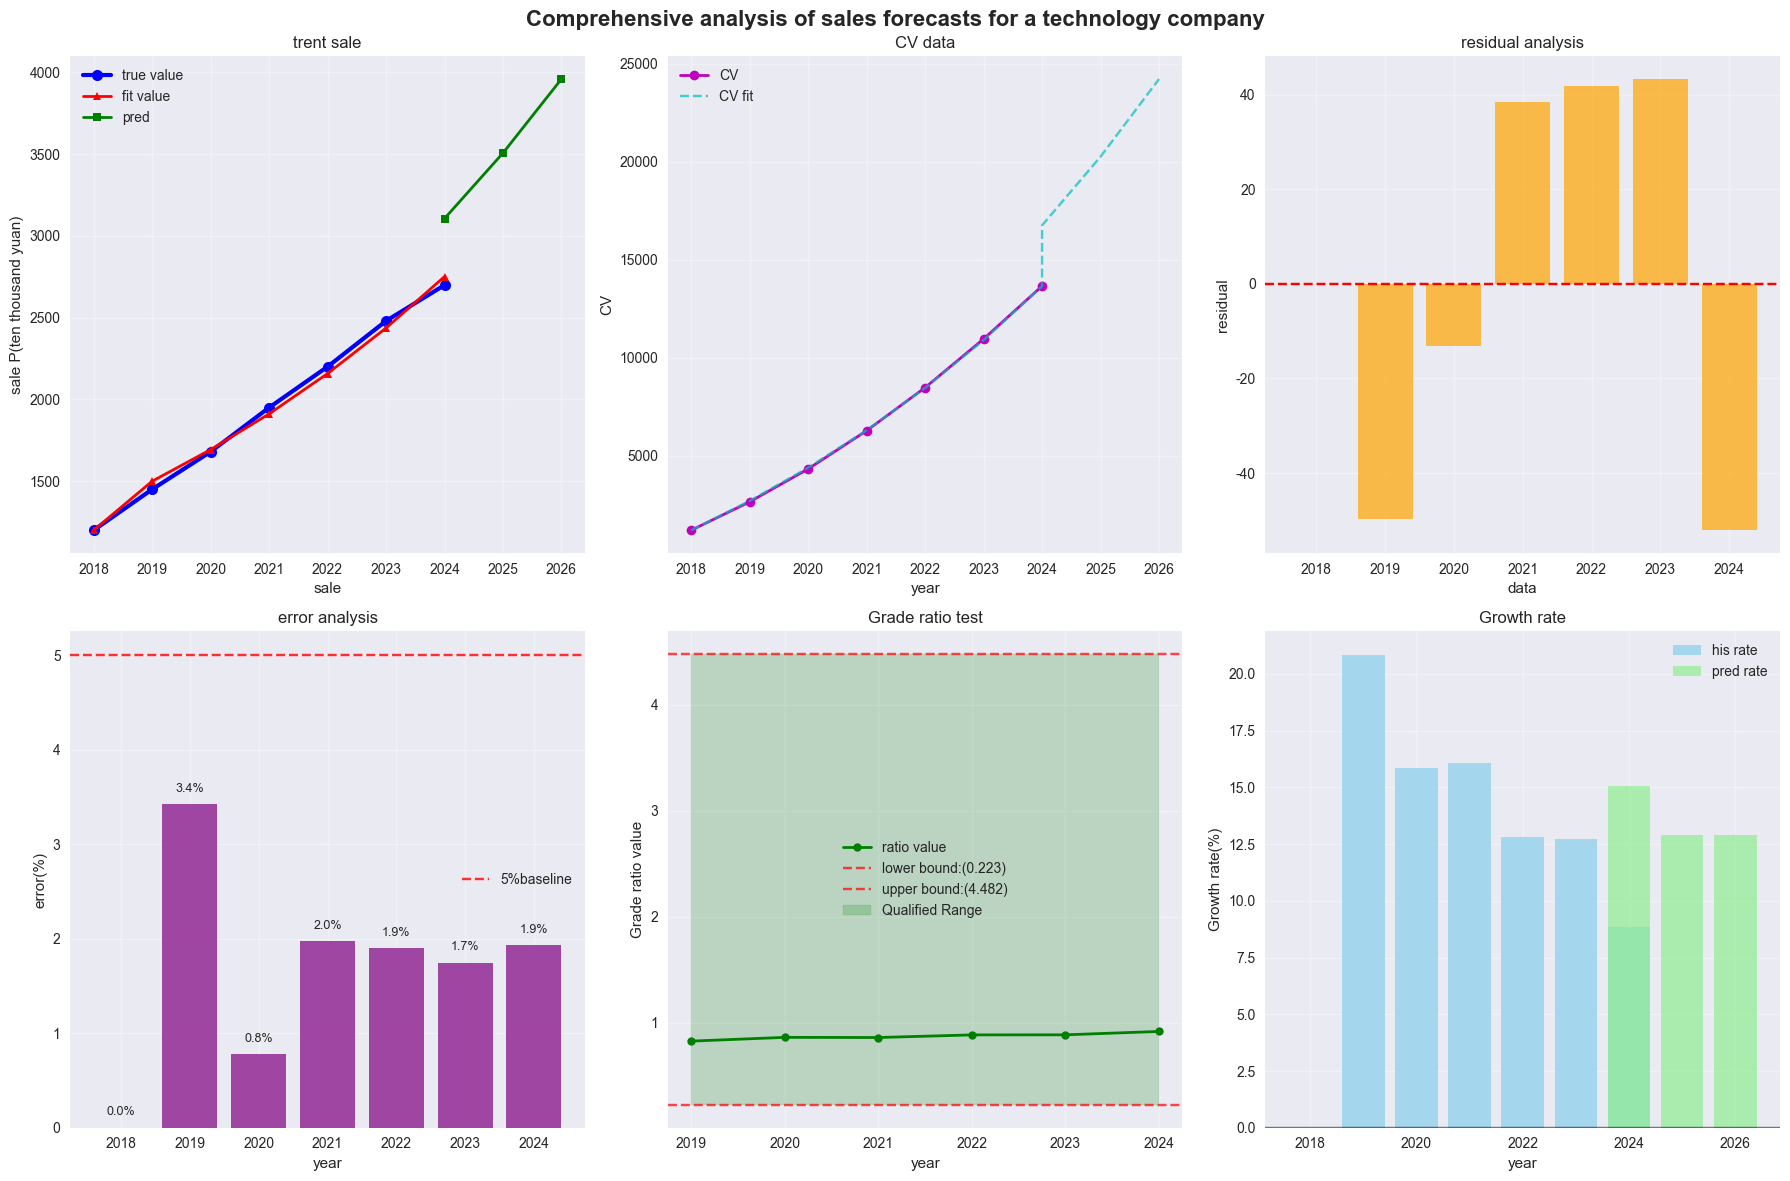

In [137]:

print(f"\n📊 生成综合分析图表...")
gm_sales.plot_comprehensive_analysis(sales_data, years, future_years, predicted_values, 
                                   "Comprehensive analysis of sales forecasts for a technology company")

# 模型比较（与简单线性趋势对比）

In [138]:

print(f"\n📈 模型对比分析:")
print("GM(1,1) vs 线性趋势预测比较")


📈 模型对比分析:
GM(1,1) vs 线性趋势预测比较


# 简单线性回归预测

In [139]:

from sklearn.linear_model import LinearRegression
X_linear = np.array(range(len(sales_data))).reshape(-1, 1)
y_linear = np.array(sales_data)
linear_model = LinearRegression().fit(X_linear, y_linear)

# 线性模型预测

In [140]:

X_future = np.array(range(len(sales_data), len(sales_data) + 3)).reshape(-1, 1)
linear_predictions = linear_model.predict(X_future)

In [141]:
print(f"{'年份':<8}{'GM(1,1)预测':<15}{'线性预测':<15}{'差异':<10}{'差异率(%)':<12}")
print("-" * 65)
for i, year in enumerate(future_years):
    diff = predicted_values[i] - linear_predictions[i]
    diff_rate = (diff / linear_predictions[i]) * 100
    print(f"{year:<8}{predicted_values[i]:<15.0f}{linear_predictions[i]:<15.0f}{diff:<10.0f}{diff_rate:<12.2f}")

年份      GM(1,1)预测      线性预测           差异        差异率(%)      
-----------------------------------------------------------------
2024    3106           2962           144       4.85        
2025    3507           3215           292       9.08        
2026    3959           3468           492       14.17       


# 建议与总结

In [142]:

print(f"\n💡 建议与总结:")
print(f"1. 模型适用性: GM(1,1)模型精度为{metrics['grade']}，适合该企业销售预测")
print(f"2. 预测趋势: 企业销售额将继续保持稳定增长态势")
print(f"3. 增长预期: 预计2024-2026年年均增长率约{np.mean([((predicted_values[i]/sales_data[-1] if i==0 else predicted_values[i]/predicted_values[i-1]) - 1)*100 for i in range(len(predicted_values))]):.1f}%")
print(f"4. 战略建议: 基于预测结果制定产能规划和市场拓展策略")
print(f"5. 监控要点: 定期更新模型，关注实际销售与预测的偏差")


💡 建议与总结:
1. 模型适用性: GM(1,1)模型精度为二级（合格），适合该企业销售预测
2. 预测趋势: 企业销售额将继续保持稳定增长态势
3. 增长预期: 预计2024-2026年年均增长率约13.6%
4. 战略建议: 基于预测结果制定产能规划和市场拓展策略
5. 监控要点: 定期更新模型，关注实际销售与预测的偏差


# 假设场景分析

In [143]:

print(f"\n🎲 情景分析:")
scenarios = {
    "乐观情景": 1.1,  # 预测值上调10%
    "基准情景": 1.0,  # 预测值不变
    "悲观情景": 0.9   # 预测值下调10%
}

print(f"{'情景':<10}{'2024年':<10}{'2025年':<10}{'2026年':<10}{'三年总额':<12}")
print("-" * 55)
for scenario, factor in scenarios.items():
    scenario_values = [value * factor for value in predicted_values]
    total = sum(scenario_values)
    print(f"{scenario:<10}{scenario_values[0]:<10.0f}{scenario_values[1]:<10.0f}{scenario_values[2]:<10.0f}{total:<12.0f}")

print(f"\n" + "="*60)
print("案例二：企业销售额预测 - 分析完成！")
print("="*60)


🎲 情景分析:
情景        2024年     2025年     2026年     三年总额        
-------------------------------------------------------
乐观情景      3417      3858      4355      11629       
基准情景      3106      3507      3959      10572       
悲观情景      2795      3156      3563      9515        

案例二：企业销售额预测 - 分析完成！


In [144]:
# # 导出结果到CSV（可选）
# print(f"\n💾 导出预测结果...")
# result_df = pd.DataFrame({
#     '年份': years + future_years,
#     '类型': ['实际值']*len(years) + ['预测值']*len(future_years),
#     '销售额(万元)': list(sales_data) + list(predicted_values),
#     '拟合值(万元)': list(fitted_values) + ['N/A']*len(future_years)
# })

# print("预测结果表:")
# print(result_df.to_string(index=False))
# print("\n提示：可使用 result_df.to_csv('销售额预测结果.csv', index=False) 导出到文件")